# Generate DE data

Generate DE data with 2 replicates

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
import pickle as pkl
import time
import string
import random
from sklearn.datasets import make_spd_matrix
from statsmodels.stats.moment_helpers import cov2corr

In [115]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg')
import memento
import memento.simulate as simulate

In [116]:
data_path = '/data_volume/memento/simulation/'


### Setup simulation

In [185]:
ifn_adata = sc.read('/data_volume/memento/hbec/' + 'HBEC_type_I_filtered_counts_deep.h5ad')
q=0.07

adata_1 = ifn_adata[(ifn_adata.obs['cell_type'] == 'ciliated') & (ifn_adata.obs['stim'] == 'control')]
adata_2 = ifn_adata[(ifn_adata.obs['cell_type'] == 'ciliated') & (ifn_adata.obs['stim'] == 'beta')]

x_param_1, z_param_1, Nc_1, good_idx_1 = simulate.extract_parameters(adata_1.X, q=q)
x_param_2, z_param_2, Nc_2, good_idx_2 = simulate.extract_parameters(adata_2.X, q=q)
common_set = np.array(list(set(good_idx_1) & set(good_idx_2)))
x_param_1 = (
    np.array([x for x,i in zip(x_param_1[0], good_idx_1) if i in common_set]),
    np.array([x for x,i in zip(x_param_1[1], good_idx_1) if i in common_set]))
x_param_2 = (
    np.array([x for x,i in zip(x_param_2[0], good_idx_2) if i in common_set]),
    np.array([x for x,i in zip(x_param_2[1], good_idx_2) if i in common_set]))
z_param_1 = (
    np.array([x for x,i in zip(z_param_1[0], good_idx_1) if i in common_set]),
    np.array([x for x,i in zip(z_param_1[1], good_idx_1) if i in common_set]))
z_param_2 = (
    np.array([x for x,i in zip(z_param_2[0], good_idx_2) if i in common_set]),
    np.array([x for x,i in zip(z_param_2[1], good_idx_2) if i in common_set]))

pos_var_condition = (z_param_1[1] > 0) & (z_param_2[1] > 0)
x_param_1 = (x_param_1[0][pos_var_condition], x_param_1[1][pos_var_condition])
x_param_2 = (x_param_2[0][pos_var_condition], x_param_2[1][pos_var_condition])
z_param_1 = (z_param_1[0][pos_var_condition], z_param_1[1][pos_var_condition])
z_param_2 = (z_param_2[0][pos_var_condition], z_param_2[1][pos_var_condition])

d1 = (z_param_1[1] - z_param_1[0])/z_param_1[0]**2
d2 = (z_param_2[1] - z_param_2[0])/z_param_2[0]**2
d1[d1 < 0] = 1e-3
d2[d2 < 0] = 1e-3

In [186]:
estimated_TE = np.log(x_param_2[0]) - np.log(x_param_1[0])
estimated_TE[np.absolute(estimated_TE) < 0.25] = 0
available_de_idxs = np.where(np.absolute(estimated_TE) > 0)[0]

num_genes = x_param_1[0].shape[0]
base_mean = np.log(x_param_1[0])
treatment_effects = np.zeros(num_genes)
num_de = 2000
de_idxs = np.random.choice(available_de_idxs, num_de)
treatment_effects[de_idxs] =  estimated_TE[de_idxs]/2

<Axes: ylabel='Density'>

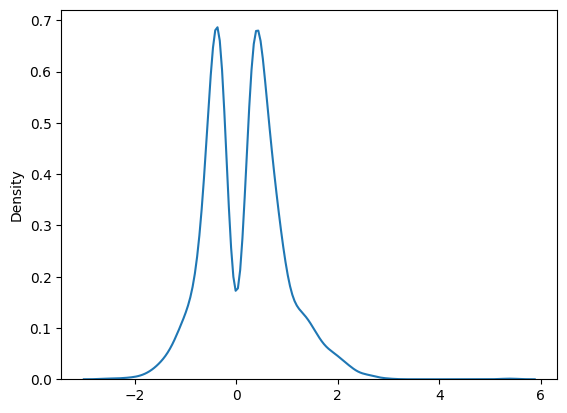

In [187]:
sns.kdeplot(treatment_effects[de_idxs])

### Generate

In [188]:
def convert_params_nb(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [231]:
n1 = 1000
n2 = 2000
num_cells = n1*2+n2*2
expr_matrix = np.zeros((num_cells, num_genes))
ind1_intercepts = base_mean
ind2_intercepts = base_mean
delta_te = stats.norm.rvs(scale=1, size=num_genes)

relative_means = np.exp(np.vstack([
    ind1_intercepts,
    ind1_intercepts + treatment_effects + delta_te/2,
    ind2_intercepts,
    ind2_intercepts + treatment_effects - delta_te/2]))
# relative_means /= relative_means.sum(axis=1).reshape(-1,1)

for i in range(num_genes):

    # intercept_diff = stats.norm.rvs(scale=0.1)
    # ind1_intercept = ind1_intercepts[i] - intercept_diff/2
    # ind2_intercept = ind2_intercepts[i] + intercept_diff/2
    # treatment_effect = treatment_effects[i]
    # delta_te_random = delta_te[i]

    # ctrl_ind1 = ind1_intercept
    # stim_ind1 = ind1_intercept + treatment_effect + delta_te_random/2
    
    # ctrl_ind2 = ind2_intercept
    # stim_ind2 = ind2_intercept + treatment_effect - delta_te_random/2

    ctrl_ind1, stim_ind1, ctrl_ind2, stim_ind2 = relative_means[:, i]


    ctrl_ind1 = ctrl_ind1*np.random.choice(Nc_1, n1)
    stim_ind1 = stim_ind1*np.random.choice(Nc_1, n1)
    ctrl_ind2 = ctrl_ind2*np.random.choice(Nc_1, n2)
    stim_ind2 = stim_ind2*np.random.choice(Nc_1, n2)

    
    ctrl_ind1_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind1, 5), size=n1)
    stim_ind1_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind1, 5), size=n1)
    
    ctrl_ind2_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind2, 5), size=n2)
    stim_ind2_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind2, 5), size=n2)

    expr_matrix[:, i] = np.concatenate([ctrl_ind1_cells, stim_ind1_cells, ctrl_ind2_cells, stim_ind2_cells])

### Perform sampling

In [232]:
_, expr_matrix = simulate.capture_sampling(expr_matrix.astype(int), q=q, process='hyper')

### Generate the dataframes

In [233]:
group = ['A' for i in range(2*n1)] + ['B' for i in range(2*n2)]
condition = \
    ['ctrl' for i in range(n1)] + \
    ['stim' for i in range(n1)] + \
    ['ctrl' for i in range(n2)] + \
    ['stim' for i in range(n2)]
obs = pd.DataFrame(
        zip(group, condition), 
        index=['cell'+str(i) for i in range(num_cells)],
        columns=['group', 'condition'])
var = pd.DataFrame(index=['gene'+str(i) for i in range(num_genes)])

### Save AnnData

In [234]:
anndata = sc.AnnData(
    sp.sparse.csr_matrix(expr_matrix, dtype=float), 
    obs=obs, 
    var=var)
de_genes = np.zeros(num_genes)
de_genes[de_idxs] = 1
anndata.var['is_de'] = de_genes.astype(bool)
anndata.var['treatment_effect'] = treatment_effect

anndata.write(data_path + 'de/anndata.h5ad')

In [235]:
norm_adata = anndata.copy().copy()
sc.pp.normalize_total(norm_adata, target_sum=1)
norm_adata.write(data_path + 'de/norm_anndata.h5ad')

In [228]:
expr_df = pd.DataFrame(expr_matrix, index=obs.index, columns=var.index)
grouped = pd.concat([obs, expr_df], axis=1)
pseudobulks = grouped.groupby(['group', 'condition'])[expr_df.columns].sum()
pseudobulks.index = [x+'_'+y for x,y in pseudobulks.index]
pseudobulks.T.to_csv(data_path + 'de/pseudobulks.csv')